In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io

from os import listdir
from os.path import isfile, join

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def RMSE(y_true, y_pred):
  return mean_squared_error(y_true, y_pred, squared=False)



In [ ]:
data = pd.read_csv('activity_data.csv')
#data

training_split = 0.7;

num_subsets = 10 # number of data points to split the time series data into
frac_history = .75

epochs = 100
num_nodes = 2000

testing_split = 1-training_split
#val_split = (2/3)*(1-training_split)
#testing_split = (1/3)*(1-training_split)

In [ ]:
# Split data - Take every other num_subset'th number and turn it into a new set

# Subsets is a list of dataframes. There are 16 dataframes, one for each bearing. 
# Each dataframe has n columns, where n is the number of subsamples of the bearing's activity data
# ie. if n = 10,  subsamples = [df of test 1 bearing 1 with 10 colomns, df of test 1 bearing 1Y with 10 colomns, df of test 1 bearing 2 with 10 colomns,...]

def subsample_data(data, num_subsets):

  for column in data:
    new_columns = []
    for i in range(1,num_subsets+1):
      new_columns.append(column + " [{}]".format(i))

  subsets = []

  for bearing in data:
    new_set = pd.DataFrame()
    for i in range(num_subsets):
      column = bearing + " [{}]".format(i)
      x = pd.DataFrame({column:data[bearing].iloc[i::num_subsets]})
      x = x.reset_index(drop=True)
      new_set = pd.concat([new_set, x], axis=1)
    subsets.append(new_set)

  return subsets


subsamples = subsample_data(data, num_subsets)




In [ ]:
print("Number of bearings = {}".format(len(subsamples)))
print("Number of time series per bearing = {}".format(subsamples[0].shape[1]))
print("Number of time series data points = {}".format(subsamples[0].shape[0]))

Number of bearings = 16
Number of time series per bearing = 10
Number of time series data points = 99


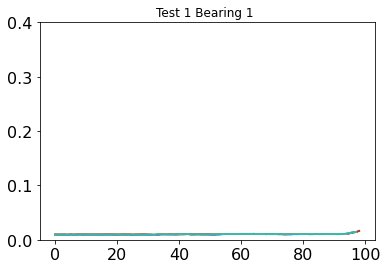

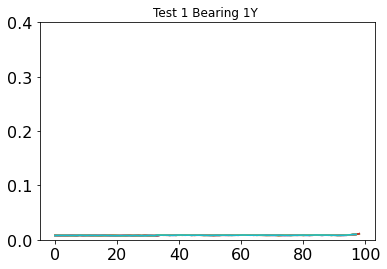

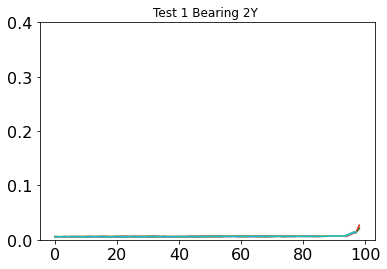

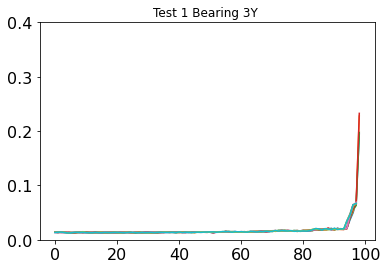

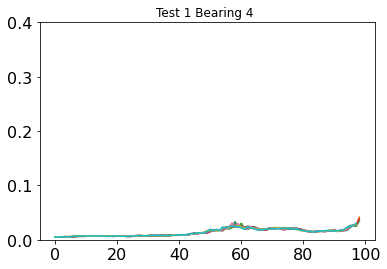

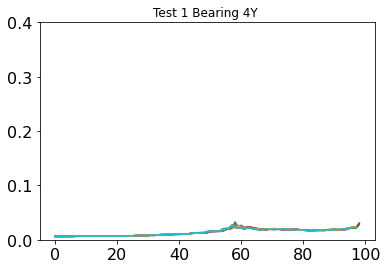

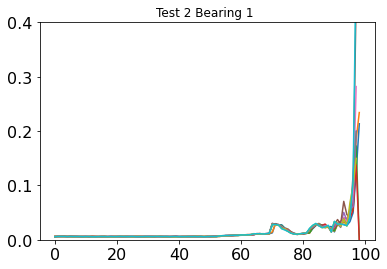

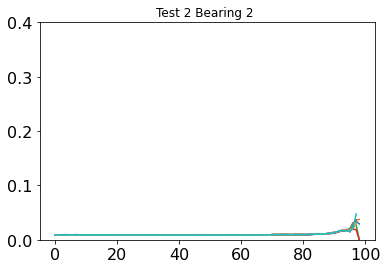

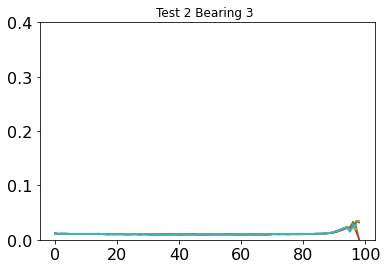

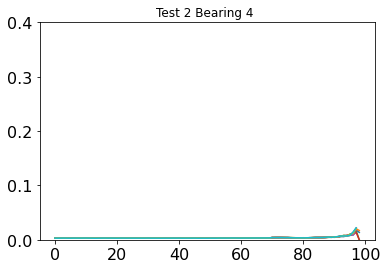

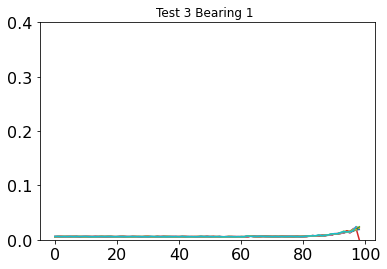

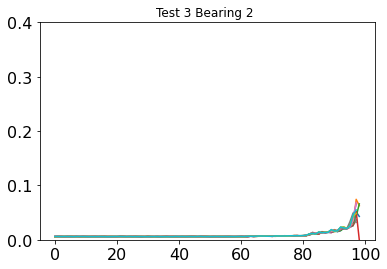

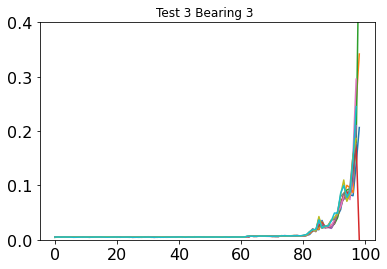

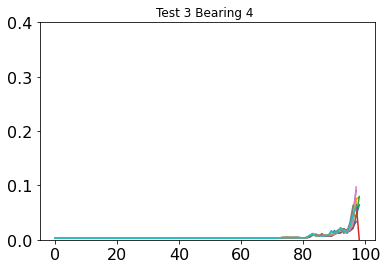

In [ ]:
for df in subsamples:
  plt.figure()
  plt.plot(df.iloc[:,:])
  plt.ylim(0,.4)
  plt.title("{}".format(df.columns[0]).replace("[0]", ""))
  plt.show()
#  print(df.columns)

In [ ]:
print(subsamples)

In [ ]:
# Create training/test split by choosing random psuedo bearings as specified by the 
# train/test split fraction


training_data = []
testing_data = []
for df in subsamples:
  train, test = train_test_split(df.transpose(), train_size=training_split, shuffle = True)#, random_state = 0)
  training_data.append(train.transpose().iloc[:-1])
  testing_data.append(test.transpose().iloc[:-1])




#training_and_val_data = []
#testing_data = []
#for df in subsamples:
#  train_and_val, test = train_test_split(df.transpose(), test_size=testing_split, shuffle = True)#, random_state = 0)
#  training_and_val_data.append(train_and_val.transpose())
#  testing_data.append(test.transpose().iloc[:-1])

#training_data = []
#val_data = []
#for df in training_and_val_data:
#  train, val = train_test_split(df.transpose(), test_size=val_split, shuffle = True)#, random_state = 0)
#  training_data.append(train.transpose().iloc[:-1])
#  val_data.append(val.transpose().iloc[:-1])




# [No fault, Outer Race Defect, Inner Race Defect, Roller Element Defect]
failure_labels = [[1, 0, 0, 0],  # Test 1 Bearing 1
                   [1, 0, 0, 0],  # Test 1 Bearing 1Y
                   [1, 0, 0, 0],  # Test 1 Bearing 2
                   [1, 0, 0, 0],  # Test 1 Bearing 2Y
                   [0, 0, 1, 0],  # Test 1 Bearing 3  -  Inner Race Defect
                   [0, 0, 1, 0],  # Test 1 Bearing 3Y -  Inner Race Defect
                   [0, 0, 0, 1],  # Test 1 Bearing 4  -  Roller Element Defect
                   [0, 0, 0, 1],  # Test 1 Bearing 4Y -  Roller Element Defect

                   [0, 1, 0, 0],  # Test 2 Bearing 1  -  Outer Race Defect
                   [1, 0, 0, 0],  # Test 2 Bearing 2
                   [1, 0, 0, 0],  # Test 2 Bearing 3
                   [1, 0, 0, 0],  # Test 2 Bearing 4

                   [1, 0, 0, 0],  # Test 3 Bearing 1
                   [1, 0, 0, 0],  # Test 3 Bearing 2
                   [0, 1, 0, 0],  # Test 3 Bearing 3  -  Outer Race Defect
                   [1, 0, 0, 0] ] # Test 3 Bearing 4


#failure_labels = [.25,  # Test 1 Bearing 1
#                   .25,  # Test 1 Bearing 1Y
#                   .25,  # Test 1 Bearing 2
#                   .25,  # Test 1 Bearing 2Y
#                   .75,  # Test 1 Bearing 3  -  Inner Race Defect
#                   .75,  # Test 1 Bearing 3Y -  Inner Race Defect
#                   1,  # Test 1 Bearing 4  -  Roller Element Defect
#                   1,  # Test 1 Bearing 4Y -  Roller Element Defect
#
#                   .5,  # Test 2 Bearing 1  -  Outer Race Defect
#                   .25,  # Test 2 Bearing 2
#                   .25,  # Test 2 Bearing 3
#                   .25,  # Test 2 Bearing 4
#
#                   .25,  # Test 3 Bearing 1
#                   .25,  # Test 3 Bearing 2
#                   .5,  # Test 3 Bearing 3  -  Outer Race Defect
#                   .25 ] # Test 3 Bearing 4

failure_labels = np.array([failure_labels]).squeeze()


In [ ]:
failure_labels.shape[0]

16

In [ ]:
print("\n\n\n\n\n\n\n\n\n\n\ntraining_data\n\n")
print(training_data)
print("\n\n\n\n\n\n\n\n\n\n\ntesting_data\n\n")
print(testing_data)
#print("\n\n\n\n\n\n\n\n\n\n\nval_data\n\n")
#print(val_data)












training_data


[    Test 1 Bearing 1 [9]  Test 1 Bearing 1 [2]  Test 1 Bearing 1 [7]  \
0               0.009700              0.009603              0.009748   
1               0.009756              0.009837              0.009547   
2               0.009898              0.009854              0.009499   
3               0.009625              0.009390              0.009307   
4               0.009771              0.009398              0.009669   
..                   ...                   ...                   ...   
93              0.010577              0.010580              0.011050   
94              0.011800              0.010718              0.011592   
95              0.013096              0.012154              0.012115   
96              0.014050              0.013282              0.014146   
97              0.014624              0.014055              0.014455   

    Test 1 Bearing 1 [8]  Test 1 Bearing 1 [1]  Test 1 Bearing 1 [0]  \
0               0.009667           

In [ ]:



def feature_label_generation(list_in, frac_train):
  X = np.array([])
  y = np.array([])
  for i, df in enumerate(list_in):
    n_steps = df.shape[0]
    n_features = round(n_steps*frac_train)
    n_labels = n_steps - n_features
    x_temp = df.iloc[:n_features].to_numpy().T
    y_temp = df.iloc[n_features:].to_numpy().T
    if not np.any(X) == 1 and not np.any(y) == 1:
      X = x_temp
      y = y_temp
    else:
      X = np.vstack((X,x_temp))
      y = np.vstack((y,y_temp))
#    if i == 0:
#      print(x_temp.shape)
#      print(y_temp.shape)
#      plt.figure()
#      plt.plot(np.linspace(0, len(x_temp), len(x_temp)),  x_temp)
#      plt.plot(np.linspace(len(x_temp), len(x_temp) + len(y_temp),len(y_temp) ),y_temp)
#      plt.show()
#      print(x_temp)
#      print(y_temp)
    if n_labels == 0:
      raise(Exception)
  print(n_steps)
  print(n_features)
  print(n_labels)
  return X, y

X_train, y_train = feature_label_generation(training_data, frac_history)
X_test, y_test = feature_label_generation(testing_data, frac_history)


print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)


failure_train_labels = np.repeat(failure_labels, repeats=y_train.shape[0]/16, axis=0)
failure_test_labels = np.repeat(failure_labels, repeats=y_test.shape[0]/16, axis=0)


input_size = X_test.shape[1]
output_size = y_test.shape[1] + failure_labels.shape[1]

print(input_size)
print(output_size)

98
74
24
98
74
24
(112, 74)
(112, 24)
(48, 74)
(48, 24)
74
28


tf.Tensor(
[[-0.10249607 -0.10512535 -0.10222775 ... -0.20163357 -0.20163357
  -0.20163357]
 [-0.10144571 -0.10494176 -0.10477757 ... -0.20163357 -0.20163357
  -0.20163357]
 [-0.10437796 -0.10437624 -0.10365874 ... -0.20163357 -0.20163357
  -0.20163357]
 ...
 [-0.17010505 -0.17024404 -0.16928765 ... -0.20163357 -0.20163357
  -0.20163357]
 [-0.17072578 -0.16992451 -0.16983536 ... -0.20163357 -0.20163357
  -0.20163357]
 [-0.1710067  -0.16953437 -0.1696407  ... -0.20163357 -0.20163357
  -0.20163357]], shape=(112, 102), dtype=float32)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 74)               149       
 n)                                                              
                                                                 
 dense (Dense)               (None, 2000)              150000    
                                               

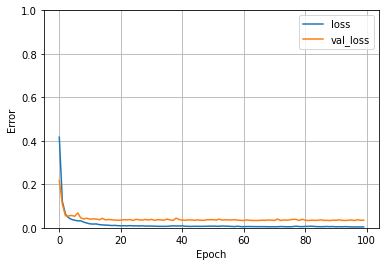

In [ ]:



train_features = X_train
test_features = X_test

train_labels = np.hstack([y_train, failure_train_labels])
test_labels = np.hstack([y_test, failure_test_labels])

normalizer = tf.keras.layers.Normalization(axis=-1)

normalizer.adapt(train_features)


input_data = np.hstack([train_features, train_labels])

input_data_normalizer = layers.Normalization(axis=None)
input_data_normalizer.adapt(input_data)
print(input_data_normalizer(input_data))
test_results = {}




def plot_loss(history):
  plt.figure()
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)






def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(num_nodes, activation='relu'),
      layers.Dense(num_nodes, activation='relu'),
      layers.Dense(num_nodes, activation='relu'),
      layers.Dense(output_size)
  ])

  model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))
  return model


dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()



#time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2, #5 fold validation
    verbose=0, epochs=epochs)

print(history.history)
plot_loss(history)
CV_MAE = history.history['val_loss'][-1]

test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
print(test_results['dnn_model'])

pd.DataFrame(test_results, index=['Mean absolute error']).T


test_predictions = dnn_model.predict(test_features)


print("\n\n\n\ntest_labels:\n\n\n\n {}".format(test_labels))
print("\n\n\n\ntest_predictions:\n\n\n\n {}".format(test_predictions))

error = test_predictions - test_labels
plt.figure()
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')



MSE_ANN = tf.keras.losses.MeanSquaredError()
print('MSE_ANN = ', MSE_ANN)








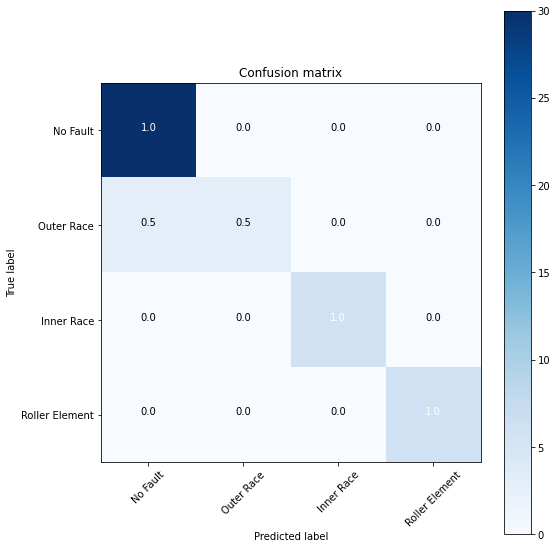

In [ ]:
predicted_failure_labels = []
for count, prediction in enumerate(test_predictions):
  max_val = np.max(prediction[-4:])
  for i, val in enumerate(prediction[-4:]):
    if val == max_val:
      prediction[-4:][i] = 1
    else:
      prediction[-4:][i] = 0
  test_predictions[count, -4:] = prediction[-4:]
  predicted_failure_labels.append(prediction[-4:])


import itertools
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / np.sum(cm,axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure



def embed_failures(failures):
  embedded_failures = []
  for failure_label in failures:
    if np.all(failure_label == [1, 0, 0, 0]):
      new_failure_label = 0
    elif np.all(failure_label == [0, 1, 0, 0]):
      new_failure_label = 1
    elif np.all(failure_label == [0, 0, 1, 0]):
      new_failure_label = 2
    elif np.all(failure_label == [0, 0, 0, 1]):
      new_failure_label = 3
    embedded_failures.append(new_failure_label)
  return np.array(embedded_failures)



predicted_failure_labels = embed_failures(predicted_failure_labels)
failure_test_labels = np.repeat(failure_labels, repeats=num_subsets*testing_split, axis=0)
failure_test_labels = embed_failures(failure_test_labels)
cm = tf.math.confusion_matrix(failure_test_labels, predicted_failure_labels)

class_names = ["No Fault", "Outer Race", "Inner Race", "Roller Element"]

f = plot_confusion_matrix(cm, class_names)


In [ ]:
print(predicted_failure_labels.shape)
print(failure_test_labels.shape)

(192, 4)
(192, 4)


In [ ]:
def partity_plot_ANN(x, y_pred, CV_MAE, title):
  # Font for figure for publishing
  font_axis_publish = {
          'color':  'black',
          'weight': 'bold',
          'size': 22,
          }
  plt.rcParams['ytick.labelsize'] = 16
  plt.rcParams['xtick.labelsize'] = 16

  # Plot Figures
  fignow = plt.figure(figsize=(8,8))

  ## find the boundaries of X and Y values
  bounds = (min(x.min(), y_pred.min()) - int(0.1 * y_pred.min()), 1.1*max(x.max(),y_pred.max()) + int(0.1 * y_pred.max()))

  # Reset the limits
  ax = plt.gca()
  ax.set_xlim(bounds)
  ax.set_ylim(bounds)
  # Ensure the aspect ratio is square
  ax.set_aspect("equal", adjustable="box")

  plt.plot(x.flatten(),y_pred.flatten(),"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

  
  ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

  # Calculate Statistics of the Parity Plot 
  mean_abs_err = np.mean(np.abs(x-y_pred))
  rmse = np.sqrt(np.mean((x-y_pred)**2))
  rmse_std = rmse / np.std(y_pred)
  z = np.polyfit(x.flatten(),y_pred.flatten(), 1)
  y_hat = np.poly1d(z)(x)

  text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ CV \: Root \: Mean \: Absolute \: Error \: (MAE) = {CV_MAE:0.3f}$ \n $ Test \: Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n  $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y_pred,y_hat):0.3f}$"

  plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
      fontsize=14, verticalalignment='top')

  # Title and labels 
  plt.title(title, fontdict=font_axis_publish)
  #plt.title("Parity Plot for ANN\n with {} Nodes".format(num_nodes), fontdict=font_axis_publish)
  plt.xlabel('Ground Truth', fontdict=font_axis_publish)
  plt.ylabel('Prediction', fontdict=font_axis_publish)



partity_plot_ANN(test_labels[:,:-4], test_predictions[:,:-4], CV_MAE, "Prognosis Parity Plot") # Prognosis

#partity_plot_ANN(test_labels[:,-4:], test_predictions[:,-4:], CV_MAE, "Classification Parity Plot") # Classification



#for i,label in enumerate(test_labels):
#  partity_plot_ANN(label[:-4], test_predictions[i,:-4], num_nodes, CV_MAE)


In [ ]:
for i, x in enumerate(test_labels):
  if np.all(x[-4:] == [1, 0, 0 ,0]):
    label = "No Fault Detected"
  elif np.all(x[-4:] == [0, 1, 0 ,0]):
    label = "Outer Race Fault Detected"
  elif np.all(x[-4:] == [0, 0, 1 ,0]):
    label = "Inner Race Fault Detected"
  elif np.all(x[-4:] == [0, 0, 0 ,1]):
    label = "Roller Element Fault Detected"

  if np.all(test_predictions[i,-4:] == [1, 0, 0 ,0]):
    pred_label = "No Fault Detected"
  elif np.all(test_predictions[i,-4:] == [0, 1, 0 ,0]):
    pred_label = "Outer Race Fault Detected"
  elif np.all(test_predictions[i,-4:] == [0, 0, 1 ,0]):
    pred_label = "Inner Race Fault Detected"
  elif np.all(test_predictions[i,-4:] == [0, 0, 0 ,1]):
    pred_label = "Roller Element Fault Detected"

  if np.all(x[-4:] == test_predictions[i,-4:] ):
    print("Correct Prediction      -     Truth: {} , Prediction: {} \n".format(label, pred_label))
  else:
    print("INCORRECT PREDICTION    -     Truth: {} , Prediction: {} \n".format(label, pred_label))

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction      -     Truth: No Fault Detected , Prediction: No Fault Detected 

Correct Prediction   

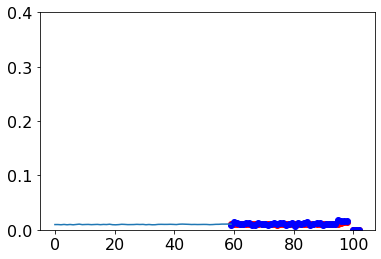

0


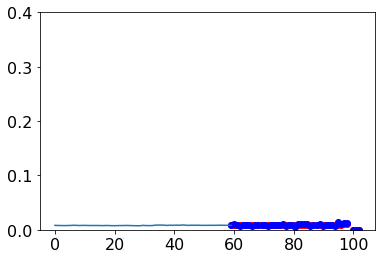

3


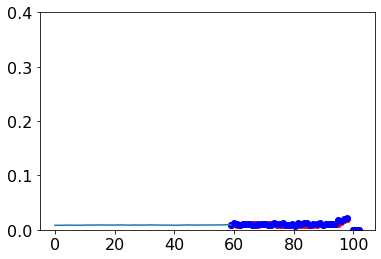

6


9


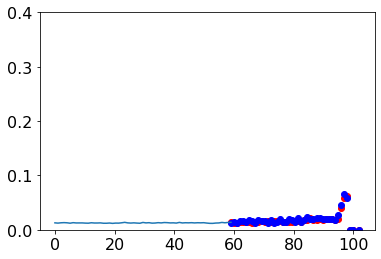

12


15


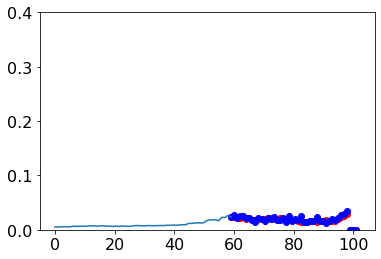

18


21


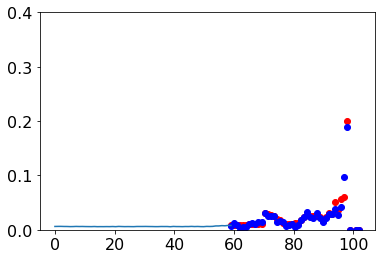

24


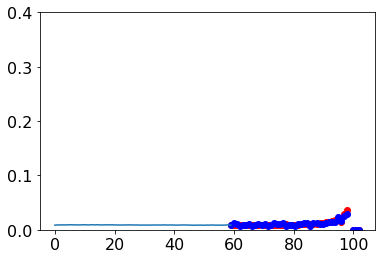

27


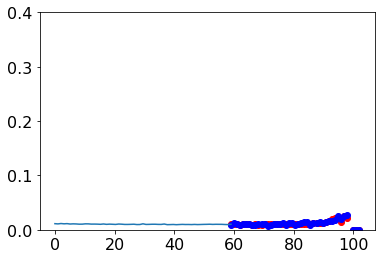

30


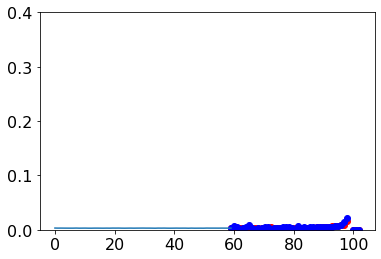

33


36


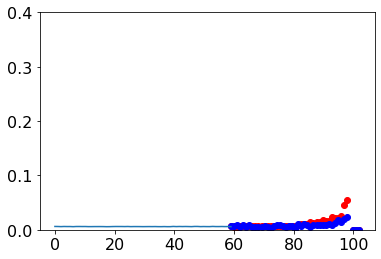

39


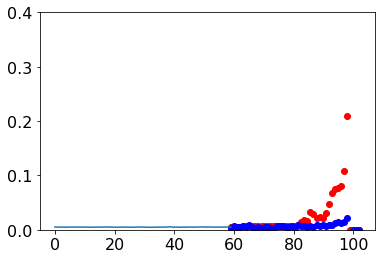

42


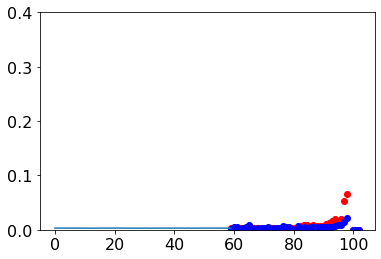

45


In [ ]:

for i, example in enumerate(test_features):
  if i % (test_features.shape[0]/16) == 0:
    plt.figure()
    plt.plot(np.linspace(0,len(example),len(example)), example)
    plt.scatter(np.linspace(len(example),len(example)+len(test_labels[i]),len(test_labels[i])), test_labels[i], c = 'r')
    plt.scatter(np.linspace(len(example),len(example)+len(test_predictions[i]),len(test_predictions[i])), test_predictions[i], c = 'b')
    plt.ylim(0,.4)
    plt.show()
    print(i)